In [250]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import math
import cmath
import scipy
import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.special as special
import numpy.ma as ma
import time
#np.set_printoptions(threshold=sys.maxsize)
pts = 5000 # number of iterator steps where neccessary
H_to_K = 1/0.000003166808534191 # conversion of Hartrees to Kelvin
H_to_GHz = 6579689.74479021 # conversion of Hartrees to GigaHertz
tol = 1e-15 # tolerance where neccessary

In [285]:
def Numerov(Energy, Num, V_r, dr, grid): # function to find psi(r) continuum state (E>0)
    global psi
    psi[0] = 0 # impose boundary condition psi(0) = 0
    psi[1] = dr # let psi(1) = the spacing length
    #print(f' psi[1] = {psi[1]}')
    ksq = 2*mu*(Energy - V_r) # wave number squared for the energy
    ksq_p = 2*mu*Energy
    #print(max(ksq))

    for i in range(2,Num):  # Numerov Algorithm, range is 2 -> N since psi(0), psi(1) already set
        #if i < 100:
       #     print(f' first term in numerator is {(2*(1 - (5/12)*(dr**2)*ksq[i-1])*psi[i-1])}')
        #    print(f' the numerator is {((2*(1 - (5/12)*(dr**2)*ksq[i-1])*psi[i-1]) - ((1 + (1/12)*(dr**2)*ksq[i-2])*psi[i-2]))}')
        psi[i] = ((2*(1 - (5/12)*(dr**2)*ksq[i-1])*psi[i-1]) - ((1 + (1/12)*(dr**2)*ksq[i-2])*psi[i-2]))/(1 + (1/12)*(dr**2)*ksq[i])
        psi = psi/max(psi)
        if i == int(0.5*Num):
            print('halfway there')
        if i == int(0.9*Num):
            print('almost there')
    
    Psi_f = psi/max(psi) # divide Psi by its largest value to qvoid it becoming too large
    Psi_prime = np.gradient(Psi_f, grid) # find the derivate over the grid r
    
    # Energy Normalization
    A_term = Psi_f[-1]**2
    B_term = Psi_prime[-1]**2
    B_coef = 1/(ksq[-1])
    U_sq = A_term + B_coef*B_term
    U = np.sqrt(U_sq)
    norm_factor = np.sqrt((2*mu)*(1/(np.pi*np.sqrt(ksq[-1]))))
    #print((U,norm_factor))
    
    Psi_Energy_Normalized = (1/U)*(Psi_f)*norm_factor
    
        
    return Psi_Energy_Normalized

# Ground State --- Lennard-Jones
## $V(r) = \frac{C_{12}}{r^{12}} - \frac{C_{6}}{r^{6}}$
## $C_{12} = 3.05\times10^{8} E_{h}a_{0}^{12}$, $C_{6} =  2\times10^{5}E_{h}a_{0}^6$

In [288]:
time_start = time.time()

R1 = 2.5 # starting posistion r1 in ao
R2 = 500 # ending posistion r2 in ao
dr1 = 0.0003 # step spacing in ao

scattering_lengths = [23.118272010998865, 23.294772927224223, 23.47102188863188, 23.647187978773193, 23.823426831925502, 23.999405940636574, 24.17522106780508, 24.35119330384819, 24.52683040828181, 24.7025339096497, 24.87794230404325, 25.05351626848902, 25.22866799412433, 25.403976102477202, 25.57906016985038, 25.75399709786118, 25.929167925228914, 26.103819650298952, 26.278536474522717, 26.45327416041281, 26.627741622053176, 26.80232713591603, 26.97670560569878, 27.150975587506338, 27.32525972628038, 27.499381777965485, 27.673407128668362, 27.8474624862435, 28.02125296431039, 28.195077301795596, 28.369020984121608, 28.542667703266964, 28.71626195545282, 28.889754036799854, 29.063166197506348, 29.23663270593716, 29.409967512225727, 29.58322412500383, 29.75640860290315, 29.92941160637291, 30.10255113717957, 30.27549038983977, 30.44842566036709, 30.621256088261728, 30.79404420921181, 30.966989091694167, 31.1396226921441, 31.312066910925818, 31.484642482774664, 31.657168637453758, 31.829651905110833, 32.002217936282825, 32.17444364199891, 32.34683304219149, 32.51915756915785, 32.69132434952043, 32.86349293064404, 33.03555535718583, 33.2076821838651, 33.37981994201011, 33.55178498115053, 33.72364702121798, 33.89558794615671, 34.06747038457139, 34.23934762347775, 34.411242159474796, 34.58286525924613, 34.75476597250081, 34.92633791407633, 35.097919488316066, 35.26971941788882, 35.441306012427425, 35.61279034934069, 35.78446559446213, 35.95593859217163, 36.12741394499274, 36.298893073243335, 36.47027625973313, 36.64178563524377, 36.81327460029353, 36.984592972221705, 37.15597820251114, 37.327432357469185, 37.49869894828373, 37.67017406870815, 37.84135303385856, 38.01267920872173, 38.18383532720373, 38.35513066430979, 38.52646312079771, 38.69769165337334, 38.86900319497565, 39.04019596368168, 39.21140638224471, 39.38264848829809, 39.553947811461974, 39.72514058158485, 39.896381690168454, 40.06766353900581, 40.2387449989234, 40.41013760710065, 40.581430408594464, 40.75260375087729, 40.92387031175787, 41.09503991429578, 41.26638722669598, 41.437743742678315, 41.60900608802441, 41.78011456698394, 41.95154298408575, 42.12278994292378, 42.294186207944264, 42.46551337992609, 42.636771444429314, 42.80828780083513, 42.97964152500535, 43.15107859025443, 43.32256325643795, 43.49407269700353, 43.665562352584644, 43.83710418513231, 44.00859104756528, 44.18019295750647, 44.35168758463926, 44.52349421527677, 44.69505978709487, 44.866665289035, 45.038462305354386, 45.210245905575874, 45.38193388380732, 45.55385219835375, 45.725707973300125, 45.897579954724314, 46.06954589471267, 46.24136466558431, 46.413495368318785, 46.585684298748504, 46.75771701107093, 46.929879207625035, 47.10205413312046, 47.27429362298639, 47.44661030869783, 47.6190577459816, 47.791436226211154, 47.9638141158306, 48.136273535677375, 48.308898004865185, 48.481528333576904, 48.654172680446585, 48.82681828281923, 48.99970326818758, 49.17234711541183, 49.34531654893292, 49.518282973273315, 49.69133604312737, 49.86444401929589, 50.03758544601891, 50.21079925542494, 50.384125120181245, 50.55746404066555, 50.730873179721485, 50.90442623076172, 51.07789548297257, 51.25146611582972, 51.42533340610605, 51.59909512141471, 51.77298386885807, 51.94697594737338, 52.121015532889466, 52.295133341549416, 52.46933995274364, 52.64355778351915, 52.8178779639753, 52.99233187837786, 53.16688432660543, 53.341461397909434, 53.516256784650636, 53.69097897789195, 53.865891866767484, 54.040771622076285, 54.215898079882486, 54.39120003515682, 54.566355560053296, 54.74169634880903, 54.91712689144703, 55.09271839801969, 55.26849972158205, 55.44421536477019, 55.62007345970823, 55.79596978515556, 55.971992389262, 56.14829753950286, 56.32457541751693, 56.500934129335015, 56.67745881586173, 56.8540064623882, 57.03077847978694, 57.207594573966894, 57.384553650356494, 57.56164319104755, 57.73882889498723, 57.91620096694365, 58.09363329231044, 58.27128620731086, 58.44885407768607, 58.62672866319602, 58.80455030770615, 58.98280067160782, 59.160861769206285, 59.3391732922414, 59.517552107388966, 59.69616887145585, 59.87489661080523, 60.053810251430825, 60.23273123834682, 60.41188041795604, 60.59111734211227, 60.77052522465539, 60.950011226682875, 61.12972289469967, 61.30964811241649, 61.489569656951076, 61.66972039836081, 61.849905847660615, 62.03028227054083, 62.210970038947934, 62.39172491798609, 62.572472474162524, 62.753547284342844, 62.93483718263248, 63.11605097126742, 63.29748646974467, 63.47924446759859, 63.66107805080651, 63.84297484663864, 64.02527229335278, 64.20742225000143, 64.39000407725736, 64.57258765490691, 64.7554159941386, 64.93836923601212, 65.12157930190341, 65.30496191598527, 65.48840264026727, 65.67207623440962, 65.85592451406795, 66.04000728768663, 66.22419354984343, 66.40870124586922, 66.5932263403548, 66.77800899461002, 66.96307243052092, 67.1481987903036, 67.3334525705659, 67.51904644890355, 67.70469200568667, 67.8906841298208, 68.0767439436979, 68.26311869438214, 68.4496781800363, 68.63637801428723, 68.82318971906008, 69.0104756303178, 69.19771041884007, 69.38528186019269, 69.57300490850893, 69.76093081074649, 69.94914125232991, 70.13754727444304, 70.32607389072827, 70.51490675160032, 70.70384519818056, 70.89316117678761, 71.0825348091728, 71.2723299217323, 71.46224020094407, 71.65233272234534, 71.84276090138711, 72.03333268976742, 72.2241084105613, 72.41509002659225, 72.6065425516525, 72.79803341002916, 72.98965183534031, 73.18171671595832, 73.37398120443287, 73.56644018780068, 73.75918250869071, 73.95216055812233, 74.14532550325508, 74.33880420392344, 74.53261035966176, 74.72650524402944, 74.92068990242596, 75.11520399770173, 75.30997577183402, 75.50486890029387, 75.70007089792391, 75.89573731788849, 76.09141019545909, 76.28749382502289, 76.48381063254715, 76.6803633451538, 76.87724800614954, 77.07445017930279, 77.27180026926779, 77.46943518848005, 77.66742852090927, 77.86572104105558, 78.06420429702162, 78.26305869613019, 78.46214001883551, 78.66161925673607, 78.86116384712739, 79.06113799145052, 79.26140821043681, 79.46192509549937, 79.66290023413917, 79.86402169340887, 80.06547397066879, 80.26722683559419, 80.46928664908184, 80.6717397725811, 80.87432934994486, 81.07740064714498, 81.28075503192909, 81.48431393282713, 81.68830905734521, 81.89263346233895, 82.0971148202143, 82.30206717920099, 82.50726084405599, 82.7128894813491, 82.91875411354194, 83.12507822143947, 83.33154143151143, 83.5384902558376, 83.74573751917066, 83.9533214816129, 84.16122568824706, 84.36946330142001, 84.57810726069792, 84.78713434379239, 84.9963383941621, 85.20612953863252, 85.41606533631965, 85.6266469475012, 85.83726823384346, 86.04840912570482, 86.25988032579866, 86.4717905540894, 86.68392497341317, 86.89661165585967, 87.10954859696952, 87.32289389173012, 87.53662738753466, 87.75078890045509, 87.96524089024582, 88.18007063117892, 88.39550137261027, 88.61110139395797, 88.82714108499802, 89.04357797026064, 89.260435316974, 89.47762055568494, 89.69540096160773, 89.91339159622703, 90.13192145704305, 90.3507968375466, 90.57004843408711, 90.7897883312792, 91.00993915872351, 91.23041587122522, 91.45144355225322, 91.67293950305299, 91.89471914432046, 92.1170557543436, 92.33972894980464, 92.56287685308988, 92.78645528985587, 93.01048957833027, 93.23500718122291, 93.45989034061789, 93.68536208128683, 93.91106522003116, 94.13744386190392, 94.36412718360208, 94.5913875158466, 94.81912116710033, 95.04718984007587, 95.27584573758193, 95.50495585457213, 95.73451452894365, 95.96456857398636, 96.19514903415367, 96.42616234290506, 96.65764762916454, 96.88963404970397, 97.12217558703003, 97.35521332915766, 97.5886517388549, 97.82270908127227, 98.05722095831402, 98.29228077210274, 98.5278830998122, 98.7639493459056, 99.00049746081558, 99.23752021437696, 99.47521339953954, 99.71328989994439, 99.95208422470142, 100.19134592916548, 100.43104531664787, 100.67144130309964, 100.91230622506303, 101.15371362542943, 101.39561378627815, 101.63822176982659, 101.88119308300816, 102.12487700564296, 102.36918290068789, 102.61397267955284, 102.85939829896374, 103.10524724921449, 103.35181761386981, 103.59897970980644, 103.84670058926837, 104.09493871544429, 104.34384963903183, 104.59341541890677, 104.8434283429498, 105.09415511474675, 105.34547932894975, 105.59746740026398, 105.85000715155684, 106.10315145212341, 106.3570002951303, 106.61143322629988, 106.86654289703117, 107.12229077321811, 107.3786649488414, 107.63563245289716, 107.89332869144755, 108.15162294875095, 108.41057548177149, 108.67025452148368, 108.93063003426207, 109.19155917674071, 109.45323610003034, 109.71559945472953, 109.9786187733818, 110.24235946433897, 110.50676593544296, 110.77182788602627, 111.03780732277937, 111.30420029093358, 111.57145587581938, 111.83946992022017, 112.1080471480115, 112.37753187911058, 112.64762214211821, 112.91852290231864, 113.19015484290397, 113.46245886935077, 113.73561109006476, 114.00956085687928, 114.28408460498291, 114.55947036046423, 114.83566969554754, 115.1125995477344, 115.39031599561852, 115.66879532191645, 115.94809104123968, 116.22816996933143, 116.50907951790127, 116.79074716884759, 117.0732375382828, 117.35650914483756, 117.64062083001913, 117.92568482741157, 118.21133154165472, 118.49811142077365, 118.78549016264859, 119.07390358541738, 119.36304160453051, 119.65306819077921, 119.94401926719185, 120.23567792362455, 120.52844874463193, 120.82187972668744, 121.11638065888533, 121.41169205574249, 121.70783787502012, 122.00502953943501, 122.30304390715385, 122.6019516956358, 122.9018553730877, 123.20271935850627, 123.50438817612377, 123.80717348019044, 124.11075471193642, 124.4154009182975, 124.72093996865134, 125.02741241379562, 125.33498696610036, 125.64340119311066, 125.9529168109277, 126.26343848697906, 126.57486225347729, 126.88734452410905, 127.20085098784168, 127.51538334331484, 127.83098545734667, 128.14753025790756, 128.46516949275986, 128.78391750470107, 129.10359701768232, 129.42444666441477, 129.74638296105894, 130.0693219049789, 130.39334227791363, 130.718564566792, 131.04475070529014, 131.37213715013593, 131.70060055974682, 132.0302587467502, 132.3610140085759, 132.69292500559325, 133.02594250648332, 133.36017090304904, 133.6955380304609, 134.03213555152777, 134.36983885380846, 134.70878880965756, 135.04883543953753, 135.3902402607889, 135.73280308899064, 136.07652979456196, 136.4215457303676, 136.7678244807327, 137.11537036081722, 137.46416642022916, 137.81418042371286, 138.16552711695033, 138.51813083825283, 138.87206369113147, 139.22730031271732, 139.58384563928755, 139.94177429533173, 140.30096736703638, 140.6615206546726, 141.0233791515743, 141.38671251993597, 141.751396178956, 142.11741744497553, 142.4849060515085, 142.8537543771084, 143.22401161410693, 143.59573503598241, 143.968939690748, 144.3435074236211, 144.71953995493834, 145.09704112429864, 145.47605621594758, 145.85658652936021, 146.23859189686792, 146.62213205322612, 147.00721992871584, 147.39374852215533, 147.78193777227796, 148.17164902490376, 148.5629433825438, 148.95583140138308, 149.35030598297033, 149.74639283778785, 150.144095431761, 150.5434830712723, 150.94444776352142, 151.34715855447655, 151.75146781554002, 152.15751877517548, 152.56529419897262, 152.9747421579455, 153.38595864023802, 153.7989029111037, 154.21354248182476, 154.6299808514519, 155.04819761510726, 155.46816829292473, 155.89005340820168, 156.31373852501326, 156.73924004074738, 157.16659963988616, 157.5958315613863, 158.02695688265717, 158.4599549078125, 158.89493639945547, 159.33179503980915, 159.77059422155003, 160.21145127210582, 160.6541391726049, 161.09888779396093, 161.54568067946954, 161.99445963235704, 162.44534093578517, 162.89826727504771, 163.3533015466953, 163.81032859530677, 164.26951485686004, 164.73084861184418, 165.19430668774962, 165.65990983131434, 166.12778005570698, 166.59785392965782, 167.0700746200921, 167.54455976234155, 168.02133806539516, 168.50037275514953, 168.98167634366882, 169.46531831642508, 169.95130323725002, 170.43966500373716, 170.93038768136898, 171.4234972610499, 171.91907872831985, 172.41704005430307, 172.91751418915462, 173.42044189087588, 173.92589979773496, 174.43383132095315, 174.94438324484221, 175.45743212897014, 175.97309906558914, 176.49140272107118, 177.01237284253872, 177.53596729262142, 178.06223194258314, 178.59123567574903, 179.12293922524933, 179.65748075083812, 180.19479085999444, 180.73484518800595, 181.27779362065007, 181.82359191698427, 182.37227349891992, 182.92389654065673, 183.47845634852214, 184.03597215396198, 184.59650086789702, 185.16001331516057, 185.7266139930158, 186.29624623122567, 186.86902987458268, 187.44497338229763, 188.02408456824497, 188.6063671037772, 189.19189096788878, 189.78065434197788, 190.3727312931984, 190.96811299955328, 191.56689859570366, 192.16900328467227, 192.77453269960324, 193.38353896652146, 193.99604551998456, 194.61199272112398, 195.23156402452628, 195.85474495943922, 196.4814983680423, 197.11191269551293, 197.74601039192135, 198.3838803855273, 199.02548982428817, 199.6709293649298, 200.3202104759662, 200.97335929578335, 201.63045557733471, 202.29150621630168, 202.95652647041868, 203.6256200360643, 204.2987900559871, 204.97606445369792, 205.65752221476214, 206.34318587189583, 207.03309499530937, 207.72733178122164, 208.42592965010363, 209.12883086137856, 209.83622926524214, 210.54809625506937, 211.2644985101675, 211.9854538600453, 212.71108456742434, 213.44129238188287, 214.17633705724464, 214.91606088580698, 215.66066565827654, 216.41012321807173, 217.16451760134578, 217.92389214334602, 218.68834450123347, 219.45780090030235, 220.2324884899448, 221.01234046171055, 221.7974745247777, 222.5879227784538, 223.383748838313, 224.18501409889672, 224.9917785234283, 225.80411783993637, 226.62209882228146, 227.4457469410248, 228.27512471102486, 229.11040957037906, 229.95150699536197, 230.79861116465756, 231.65165878351775, 232.51089994809035, 233.37625354106018, 234.24785073433762, 235.12577480558434, 236.01007102508476, 236.90082731920378, 237.79813413889616, 238.7020178808438, 239.61262536744965, 240.53003551142518, 241.45423623170484, 242.38542249944152, 243.3236481183189, 244.2689658414395, 245.22145835949183, 246.18125540138075, 247.148442083059, 248.12306292777384, 249.10524796017222, 250.09511674116058, 251.0927139122345, 252.0981619382635, 253.1115545977546, 254.1329966692117, 255.16260158650948, 256.2004681741267, 257.24668950260747, 258.3013656912495, 259.364628209206, 260.43659968882326, 261.5173521258456, 262.6070630940786, 263.70580626822783, 264.8136551586426, 265.9308386490494, 267.05739257064386, 268.19349934388634, 269.33927288820536, 270.49480614656574, 271.6602937289903, 272.83585792670533, 274.0215954334499, 275.2176578305826, 276.4242331940389, 277.64142965752916, 278.8693834666248, 280.1082964275934, 281.35828651432837, 282.61950000452697, 283.89211932319233, 285.1763273691477, 286.47222778454676, 287.78007271928504, 289.0999741385099, 290.43211569889286, 291.77670875119344, 293.1339053631286, 294.50388419484966, 295.8868636885036, 297.28304027744343, 298.69260419682115, 300.11574314178665, 301.55266650655904, 303.0036039780829, 304.4687594432814, 305.9483566705865, 307.4425997617436, 308.9517553578037, 310.47602799217464, 312.01563048080806, 313.5708649184339, 315.14194727254255, 316.729118893976, 318.33269122167496, 319.95285718822515, 321.58995044223445, 323.24420750694463, 324.91592185364846, 326.6053716008108, 328.31287064562576, 330.03872145401374, 331.78322158245004, 333.5466685209112, 335.3294150056412, 337.1317865004599, 338.9541045527723, 340.79670868224576, 342.65998449828413, 344.5442639009616, 346.449925834164, 348.3773526921678, 350.3269203657878, 352.29902283242967, 354.29410094449776, 356.31252250654154, 358.3547436030398, 360.42119272526844, 362.5123058783751, 364.62854808325574, 366.7703963459286, 368.93832645093676, 371.1328335633886, 373.35442128713595, 375.6035934884792, 377.88089430501776, 380.1868827251846, 382.5221121930702, 384.88713529655894, 387.28256876359586, 389.70899959737164, 392.16706092071075, 394.6573773180564, 397.1806076238643, 399.73744812392505, 402.32855510436355, 404.9546629207514, 407.6164899138372, 410.3147993770568, 413.05034644210775, 415.82393822980504, 418.63638467336705, 421.4885317178505, 424.38122970227215, 427.31538724718445, 430.2919120606366, 433.3117564324622, 436.37586881340843, 439.4852697940313, 442.6409851302623, 445.84407253289777, 449.0956391371742, 452.3968057345465, 455.7487312688604, 459.15263128663867, 462.60973406992605, 466.1213328288401, 469.68872373278265, 473.3132954014205, 476.9964464824424, 480.73962872497964, 484.5443471155154, 488.4121534234504, 492.3446729254882, 496.3435423474856, 500.4105000026625, 504.54731793428437, 508.75583013484794, 513.0379579304761, 517.3956742471688, 521.831028545496, 526.3460963387478, 530.9431689270751, 535.6244552565917, 540.3923535960797, 545.2492630292004, 550.1978447182789, 555.2406405714753, 560.3804608209905, 565.6201193922406, 570.9626188550684, 576.4110948582507, 581.9686493209208, 587.6387178001116, 593.424855648743, 599.3304958098528, 605.3595353643889, 611.5159720060817, 617.8038377881661, 624.2274728167076, 630.7913633124151, 637.5001871755959, 644.3588121049003, 651.3723999506923, 658.5462966378847, 665.8860948137894, 673.397693026593, 681.0871821637487, 688.961053440038, 697.0260908862074, 705.2893232031622, 713.7582879775642, 722.4407413087895, 731.344954318431, 740.4795195894663, 749.8537369362327, 759.4770890886831, 769.3596424297132, 779.512187351771, 789.9459170480009, 800.6728011376113, 811.7055022504195, 823.0572706808066, 834.7422021136725, 846.7753425528714, 859.1725260223501, 871.9505785794431, 885.1274511448071, 898.7223316211471, 912.7550437881632, 927.2476600599454, 942.2233376713924, 957.706073685038, 973.7229680558817, 990.3016249758011, 1007.4730169344892, 1025.2682706890932, 1043.72395143604, 1062.8754870922228, 1082.7647672040016, 1103.4350909058326, 1124.9328828794498, 1147.3102008333549, 1170.6210444477445, 1194.9267374785024, 1220.2895945466632, 1246.7833765709042, 1274.483809818323, 1303.4764744523654, 1333.8527378827032, 1365.7159253751222, 1399.1798877799195, 1434.3618975818345, 1471.406470501572, 1510.4592963631108, 1551.6863520747145, 1595.2802920501192, 1641.4605120830197, 1690.4479235792119, 1742.510648737232, 1797.9523264909199, 1857.1106333673079, 1920.3742185893047, 1988.1847754503342, 2061.0526120272407, 2139.563295209347, 2224.402313124711, 2316.3671157058475, 2416.397120959136, 2525.590370424556, 2645.282559874489, 2777.057281452176, 2922.8530876535683, 3085.040468632654, 3266.482620779692, 3470.916435125633, 3702.983187026742, 3968.6571224301915, 4275.846836950877, 4635.072275896211, 5060.881890377108, 5573.4808882408415, 6202.621760052971, 6993.107048492643, 8016.120453958647, 9391.717134045519, 11341.510363670053, 14316.242740615904, 19418.95812763317, 30187.673964690628, 67930.85046869452, -269652.6174290021, -45124.916832271294, -24603.120603474403, -16905.4596077338, -12873.305370987267, -10390.119534129384, -8708.466128171483, -7493.761850438987, -6575.169763392489, -5856.230101703819, -5278.297690674371, -4803.5608362236535, -4406.5769548575345, -4069.7471683956105, -3780.3515662799314, -3529.0222061102936, -3308.7045580244408, -3113.9921427462714, -2940.70589300862, -2785.4404783416985, -2645.529112108226, -2518.82491815703, -2403.5339020068045, -2298.161139947846, -2201.5072613256925, -2112.508664272709, -2030.3190486009535, -1954.1434143614872, -1883.3835333865368, -1817.4545377066447, -1755.8976447960151, -1698.2678562714593, -1644.2111982641727, -1593.4496861968728, -1545.6182665351694, -1500.5033840301744, -1457.8838611632568, -1417.547299723827, -1379.320169966627, -1343.0465976347807, -1308.5701044729267, -1275.7643499662956, -1244.509164044983, -1214.6960158240904, -1186.2389684075422, -1159.0319441516922, -1133.0059540199818, -1108.0751508981452, -1084.1763992476078, -1061.2474401966854, -1039.2331085938013, -1018.0714076142697, -997.7221147626933, -978.1354467033509, -959.2673607907614, -941.0825510270405, -923.5426619502565, -906.6121055497671, -890.2659457900407, -874.4657040499083, -859.1880866335484, -844.4100137851597, -830.1061462215883, -816.2532914595674, -802.8297567306535, -789.8144686295537, -777.19279175293, -764.9435174713329, -753.0514038520118, -741.5023228179949, -730.2823667996705, -719.3722416472583, -708.766923523695, -698.4466193732518, -688.4053254709263, -678.6287107811257, -669.1065665684241, -659.8304484850371, -650.7893665937958, -641.9754925656756, -633.3796878001408, -624.994402498602, -616.8124678851411, -608.8250439309627, -601.0259058220403, -593.4106464367371, -585.9685048978802, -578.6968853610825, -571.5872722414833, -564.637606433899, -557.8391554722815, -551.1897620147847, -544.6834461451848, -538.3152166561904, -532.0801726518403, -525.9766989904431, -519.997717904027, -514.1401518629976, -508.4027697750719, -502.7779281149728, -497.26564212220694, -491.8602571278768, -486.55937463556177, -481.35945372509667, -476.2583010986283, -471.2581648130979, -466.34462717606, -461.52382285615096, -456.7923653507047, -452.14445298897635, -447.5815127279801, -443.1000856456644, -438.69592476774915, -434.36866629712193, -430.1175009096542, -425.9381858967624, -421.8295035829045, -417.79088581666355, -413.81906745315587, -409.9129584360428, -406.07144064516626, -402.2918403256368, -398.5736751857007, -394.9141877744155, -391.31333962184004, -387.768611152201, -384.2800047701812, -380.84471625690446, -377.46179022948525, -374.13105760681236, -370.8505381996558, -367.61923388050235, -364.43542002040084, -361.29892135252663, -358.2078758373728, -355.16156468757373, -352.1598279177031, -349.201305753872, -346.28390094324305, -343.40904921562634, -340.5729408500822, -337.77628910063567, -335.01873070716954, -332.29860369636333, -329.61561309802954, -326.9684907499824, -324.3575999662402, -321.7798818713027, -319.2373412757432, -316.7275591929478, -314.2507833855701, -311.80604274700465, -309.3925995504078, -307.01005577247, -304.6574903557495, -302.334676195435, -300.0410973296089, -297.7753499973563, -295.5377434242621, -293.3274645580023, -291.14428758678235, -288.9873328377989, -286.8560094482357, -284.7503655406073, -282.66977733329037, -280.6139412538206, -278.5817431698471, -276.57309472954546, -274.5879482293409, -272.6251964411057, -270.6852506041117, -268.7670969267499, -266.87038640921065, -264.99520338624274, -263.14112681513126, -261.30679000935595, -259.49308382898386, -257.69960501937663, -255.92497456981008, -254.16974583195955, -252.43367535519022, -250.71477970225382, -249.01582358176572, -247.33347157610373, -245.6699768111915, -244.02237886471096, -242.39363585726036, -240.78039617507224, -239.18382334338415, -237.60379741892288, -236.03953452988597, -234.49141490256338, -232.95811089032972, -231.44109406801584, -229.93883966377058, -228.45048620301313, -226.97764145229272, -225.5184811205125, -224.07379002409996, -222.64332864953286, -221.22587125131247, -219.82226426104128, -218.43219804303473, -217.05503045701005, -215.69075696691056, -214.3395385913439, -213.00044250999144, -211.67410657763128, -210.35938299008308, -209.0575623521798, -207.76670214895623, -206.48789754466662, -205.22030718865616, -203.96440008117503, -202.71960034490982, -201.48563288464067, -200.2625757597327, -199.05031796663732, -197.8486712205892, -196.65765666532445, -195.47616100160957, -194.30538064023713, -193.1451668973117, -191.9941990689904, -190.85268525520513, -189.72102692143926, -188.5991327133485, -187.48627460623942, -186.38263810251885, -185.28827928248816, -184.20314431635057, -183.12666548426455, -182.05878237027108, -180.99972277120239, -179.94918138213046, -178.90702094200807, -177.87308212049538, -176.84756280445706, -175.83021924171325, -174.8205607629576, -173.81915509460688, -172.8253411174882, -171.83913625055501, -170.86067576903346, -169.89005130419017, -168.9266395232927, -167.97002187090163, -167.02156491637876, -166.08002401913555, -165.14502293138122, -164.21746479016642, -163.29677457135682, -162.38279845870005, -161.47567327402112, -160.57538022809933, -159.68150167794326, -158.7942224327941, -157.91315162156852, -157.03857006537106, -156.17058119259718, -155.30796195757537, -154.4526389153739, -153.60244992902412, -152.75867878898276, -151.9208607195155, -151.0888134303282, -150.26227268536053, -149.44167041683224, -148.62675317489092, -147.81789993917147, -147.01385878051119, -146.21593983813716, -145.42288815057796, -144.63541224158237, -143.8532521894706, -143.07635234533592, -142.30442463668933, -141.5381539967825, -140.77651662784274, -140.02008014661575, -139.26820733516817, -138.52183136726632, -137.78010120431156, -137.04329418510608, -136.3107844866878, -135.58371476389058, -134.860343468367, -134.1425096442706, -133.4287465965044, -132.71962062477616, -132.01483078743811, -131.31479990032315, -130.61888868672116, -129.9271114411875, -129.239614789491, -128.556761284474, -127.87791299628323, -127.20312518803806, -126.53251452735188, -125.86609779144233, -125.20377605187454, -124.54543002217255, -123.89040897137698, -123.23990471159613, -122.5935363708704, -121.95035114444246, -121.31110462225001, -120.67591269928657, -120.04427965593662, -119.41625421405314, -118.79198954746461, -118.17115989084398, -117.55400749922802, -116.9405169789717, -116.3302665235725, -115.72375428726377, -115.12057303150961, -114.5208855086528, -113.92447412158477, -113.33144574602913, -112.74163508234803, -112.1550505824109, -111.57196866442831, -110.99198093566709, -110.41539710414995, -109.84175024299272, -109.27125011079882, -108.7039419107052, -108.13950505331961, -107.57835477490933, -107.01984949211027, -106.46449279556143, -105.91257486212027, -105.3632820274779, -104.81681025557121, -104.27334903816626, -103.73230977056927, -103.19456228424794, -102.65943615225943, -102.1272731309149, -101.59763033576071, -101.07097004379582, -100.54660521692034, -100.02551996026249, -99.50686385254902, -98.99056550426813, -98.47693937180134, -97.96611183924193, -97.45773381095839, -96.95214369411084, -96.4487515842532, -95.94822631866901, -95.44920041679393, -94.9541803698146, -94.46039248497365, -93.96930607089674, -93.48071898849507, -92.99470289230652, -92.51046056024082, -92.02938699517046, -91.54992435936168, -91.07296293812921, -90.59839895851263, -90.12618026884732, -89.65587946351964, -89.18809416478335, -88.72207319796762, -88.25883797068478, -87.79738619466043, -87.33789270461473, -86.88105234229174, -86.42607158895986, -85.97290165935513, -85.52215399491365, -85.07349235050528, -84.62669781466164, -84.18199740256026, -83.73931044788549, -83.29870884720431, -82.85996669908748, -82.42338351556688, -81.98818210522094, -81.55557024368004, -81.12464417510492, -80.69554369406447, -80.26843957199918, -79.84298760582308, -79.41945490772127, -78.99800964608528, -78.57808578021647, -78.16027874819564, -77.74394358462133, -77.32943078277816, -76.91701879869392, -76.50616044632392, -76.09703433820741, -75.68957386495141, -75.28396973990363, -74.87979700529165, -74.47773363052934, -74.07711765456615, -73.678002681973, -73.28054686513784, -72.88492643359596, -72.49098593113506, -72.09864405822562, -71.70783680566048, -71.31860597070775, -70.9308383344926, -70.54473144409121, -70.16004411038308, -69.77716105504334, -69.39567222455136, -69.01578072868266, -68.63732046428727, -68.26021537893861, -67.88468043845393, -67.51094307547336, -67.13832732488332, -66.76707240008761, -66.39751074336397, -66.02932225669535, -65.66253170019398, -65.29702347577125, -64.93316198392455, -64.57044582777247, -64.20910717668997, -63.84925855861957, -63.49092491507752, -63.13373586765101, -62.77802013462969, -62.42331719999611, -62.07033891790143, -61.71838245867469, -61.367933293880704, -61.01872995377777, -60.67060995896152, -60.32376792264038, -59.978344416683726, -59.63430446938437, -59.29140144384427, -58.94949626992271, -58.60939217929087, -58.269924264783064, -57.931818534851296, -57.59503433486955, -57.25933821111221, -56.924770363257686, -56.591860535491676, -56.25969210823263, -55.928613425080535, -55.598751016901105, -55.27027606553085, -54.94275666147781, -54.61635425237604, -54.290995960313, -53.96693637247509, -53.643848160224664, -53.321971657400454, -53.000924344835035, -52.68132983728528, -52.36246588564317, -52.04496216897542, -51.728329154568186, -51.41292860941971, -51.09852987983701, -50.7850603202779, -50.47259577032995, -50.16128469790926, -49.85098012922283, -49.54153551779171, -49.233489824466666, -48.92601780783003, -48.6197595236205, -48.31431422398606, -48.00990575483973, -47.70654229460014, -47.40428288295769, -47.10263270328146, -46.80201756413045, -46.502746747577135, -46.20403885929162, -45.906390961541796, -45.60972161523295, -45.31380027781188, -45.01886088980746, -44.72499366729971, -44.431965917264414, -44.13955365821852, -43.84827036790255, -43.55785491376142, -43.268197303388554, -42.9795972901738, -42.69190260774132, -42.404988601241314, -42.11888452334638, -41.833554815044096, -41.54922307544467, -41.265489643122294, -40.98289529501837, -40.7011976629421, -40.42010233805468, -40.13974653586347, -39.86027767588943, -39.581701286910096, -39.30396836634714, -39.02712298552469, -38.75090203688776, -38.47540144416095, -38.20070813541013, -37.92698316154122, -37.6537311884181, -37.38152925181367, -37.1100563417152, -36.8392113492107, -36.569237768819384, -36.30001192900201, -36.031341906680076, -35.763487566799824, -35.49640363769836, -35.23031473538582, -34.964411602760514, -34.69976913780379, -34.435715200329504, -34.172089154689175, -33.9091867628262, -33.6474554923903, -33.38599072598403, -33.12554717126958, -32.86545739937893, -32.606398598236865, -32.347551257963964, -32.08983693465401, -31.83239349043635, -31.576007937009784, -31.319979039236234, -31.064960984681928, -30.810277058640317, -30.55660579853162, -30.303282764516943, -30.050366128156817, -29.798415127368678, -29.547124408821322, -29.2965766557788, -29.046466967383946, -28.797016603322383, -28.548088841145002, -28.29994961978896, -28.05243835642156, -27.805176239676257, -27.55895286836178, -27.313205669644653, -27.06789680394332, -26.823629997507837, -26.579496111881145, -26.33612912944091, -26.09325559590247, -25.851031622907467, -25.60931978083698, -25.3683451396468, -25.127783875949472, -24.887802544924256, -24.64846243877055, -24.409697295323003, -24.17135142737905, -23.93377090743151, -23.696423044976832, -23.45982844293824, -23.223956641894876, -22.98835742272789, -22.753293532926257, -22.51892146562343, -22.284934939976406, -22.05156155170826, -21.818611521772553, -21.586353344668698, -21.35444305568685, -21.123198801924453, -20.892434438917935, -20.662123536432752, -20.432280412820003, -20.203012875511977, -19.97411816336007, -19.745880409185098, -19.51813479904884, -19.29084491598715, -19.064147624560004, -18.8376478168402, -18.611863419867184, -18.38656053686195, -18.161720062015185, -17.937192804878617, -17.71325259012585, -17.489883288842094, -17.26687201330763, -17.04408332609949, -16.821982042630736, -16.600500836435724, -16.379333828180254, -16.15863958214059, -15.938374672291179, -15.71845116591504, -15.498869032566512, -15.280076603373685, -15.061588739030777, -14.843529226893946, -14.625889814330863, -14.40870814482681, -14.191869651693267, -13.97538939009355, -13.759369453569208, -13.543923590621697, -13.328915612456814, -13.114277169347433, -12.899800783439293, -12.68612223226887, -12.472542531279851, -12.259539615332024, -12.046897655791925, -11.834666943678476, -11.62290063073152, -11.411389609306369, -11.200267814452635, -10.989592050377592, -10.779275875220266, -10.569518192969486, -10.359827605455614, -10.150606487469593, -9.941967410595417, -9.73361618256605, -9.525620387493476, -9.317847368675688, -9.11075306632289, -8.903741380912951, -8.697333139142275, -8.490995668758814, -8.28530553159107, -8.079826419136488, -7.874717739985838, -7.670089594394501, -7.465534707249164, -7.261725265286932, -7.05788088483131, -6.854562592952889, -6.651542662127883, -6.4488362182579975, -6.246712972581531, -6.044720390922583, -5.843153297718614, -5.641738199358856, -5.440834443841115, -5.240048591592833, -5.039706295372306, -4.839922098938989, -4.640182355554233, -4.440821310782478, -4.241763729387076, -4.043123918564357, -3.8448244757515293, -3.6466254263657114, -3.4488988708605195, -3.251450861195774, -3.054410065517469, -2.8575142659838217, -2.6609390993965913, -2.4647813928558873, -2.2688951307264236, -2.073204024700976, -1.877744945266565, -1.6827911430344764, -1.4881974746109792, -1.2936554845295445, -1.0994988945999884, -0.9056132870736688, -0.7120677037043848, -0.5187183575514295, -0.32578259353631883, -0.13301944264996585, 0.05957401838649711, 0.2516785585493143, 0.4434683367640969, 0.6350473378573772, 0.8265545804384059, 1.0175354838247868, 1.2083974581380197, 1.3989309672040573, 1.5893186411429492, 1.779194610525019, 1.9690575411482412, 2.158569315073716, 2.347693429948022, 2.536791456151405, 2.725480905901154, 2.9139734193211027, 3.1021451434212066, 3.2901959695490683, 3.47788978398774, 3.6654303733762283, 3.8527100304983355, 4.039545753482576, 4.226340236781417, 4.412920485777448, 4.59912117788647, 4.785199830015801, 4.971114576970308, 5.156600822735908, 5.341858139833938, 5.527062793619635, 5.711811771488278, 5.896371957290569, 6.08072580781188, 6.264972602809001, 6.448944495354714, 6.632587360712595, 6.816209448870872, 6.999496367141688, 7.182402566959827, 7.365566706136354, 7.548110318431453, 7.730411095327079, 7.912746208367163, 8.094729943109899, 8.27648207014134, 8.45812352763352, 8.639614069350785, 8.820812899761352, 9.001647633302804, 9.182489379317614, 9.362974567445711, 9.543428852510674, 9.723520092341731, 9.903542510446462, 10.083479093852413, 10.26296300851327, 10.44239887903439, 10.621581844514305, 10.800577970059429, 10.979411609056065, 11.158229408373591, 11.336336350723613, 11.514835229752793, 11.69296514053701, 11.870840726384372, 12.04848346410144, 12.226106773467757, 12.403466145563709, 12.580628709105003, 12.75770631841531, 12.934517284797266, 13.111160937251743, 13.287757359391296, 13.464052115587045, 13.640213072868956, 13.816151394593883, 13.992081395619268, 14.167698641394836, 14.34326870048967, 14.518447369295004, 14.693763338692868, 14.868814478688877, 15.043651465739494, 15.218459871467674, 15.392912844315642, 15.567259046523036, 15.741641018593501, 15.91570149354112, 16.08958563226492, 16.263462505130974, 16.43718848847462, 16.610574468729297, 16.783924282655686, 16.95713937626448, 17.130177742585875, 17.303102072370333, 17.475956455546008, 17.648486108905086, 17.821030306191815, 17.99337634463553, 18.16558439124201, 18.337834026708336, 18.509806747228815, 18.681593085130665, 18.853263021101508, 19.02487160883594, 19.196227318899567, 19.367563059360496, 19.538738160710334, 19.709972554888427, 19.880938460190475, 20.051645471261367, 20.222315049955416, 20.39291612391829, 20.563361480487703, 20.733724339560393, 20.903875173997474, 21.074000501438626, 21.24397713961628, 21.413775127820365, 21.58351713803897, 21.75320416091549, 21.922765619138556, 22.092159666282143, 22.26160416842267, 22.430684205333485, 22.599662681646514, 22.76869533012865, 22.937724741371095, 23.106583772295274, 23.275241034338666, 23.443643248162644, 23.612142076049345, 23.780529706900676, 23.948807944484972, 24.117071890984924, 24.285002682700437, 24.453096788797854, 24.62092865701098, 24.78878002114154, 24.956541474856763, 25.124244791193263, 25.29176148787479, 25.459344158993606, 25.626547374890144]
C12_coefs = np.linspace(3.17e8, 3.28e8, 1800)

N_big = int((R2-R1)/dr1)
print(N_big)
ipap_big = np.arange(1,N_big, 1.0)
R_grid = R1 + dr1*ipap_big

C12 = 3.05e8 # C12 coefficient in Eh*ao
C6 = 2e5 # C6 coefficient in Eh*ao
VLJ = (C12/(R_grid**12)) - (C6/(R_grid**6)) # standard Lennard-Jones interatomic potential



Eo = 3.166808534191e-12 # inital particle energy, 1uK in Hartrees

me = 9.1093837e-28 # electron mass in grams
mNa_g = 3.8175458e-23 # sodium mass in grams
mK_g = 6.4924249e-23 # potassium mass in grams
mNaK_g = mNa_g + mK_g # sodium potassium mass in grams
mNak = mNaK_g/me # sodium potassium mass in au
mu = (mNak**2)/(2*mNak) # reduced mass of sodium potassium 

hbar = 1.0546e-27 # reduced Planck constant in cgs
e = 4.8032e-10 # electron charge in cgs
ao = (hbar**2)/(me*e**2) # Bohr radius in cgs

min_v = min(VLJ)
K_max = np.sqrt(2*mu*(Eo - min_v))
lambda_min = (2*np.pi)/K_max
print(lambda_min)




psi = np.zeros(N_big-1)  # initializing psi(r) as array of zeros
Psi_1 = Numerov(Eo, N_big-1, VLJ, dr1, R_grid) # wave function Psi
#plt.plot(r, Psi_1, label = f' $\\psi(r)$', color = 'red') 

plt.hlines(0,0, R_grid[-1], color = 'black')
#psi_1prime = np.gradient(Psi_1, r) # first posistion derivate of wave function Psi
plt.plot(R_grid, Psi_1, label = f' $\\psi(r)$', color = 'red') 
#plt.plot(r, Vr*1e0, label = 'Scaled Lennard-Jones Potential', color = 'purple')
plt.xlabel('$ interatomic$ $distance$ $r$ $(a_{o})$')
plt.ylabel('$\\psi(r)$ ($\\frac{1}{\\sqrt{a_{o}}}$)')

plt.plot(R_grid, VLJ, color = 'purple', label = 'Lennard-Jones Potential')
plt.xlim(2,20)
#plt.ylim(min(VLJ) - 2, 1)
plt.ylim(-1e-12, 1e-12)
plt.ylabel('$V_{LJ}(r)$ $(E_h)$, $\\psi(r)$ ($\\frac{1}{\\sqrt{a_{o}}}$)')
plt.xlabel('Interatomic Distance r $(a_o)$')
plt.title('Ground State Potential for NaK-NaK')

time_end = time.time()
time_duration = time_end - time_start
print(f'Took {time_duration:.3f} seconds')

1658333
0.003261711756590711


C:\Users\nienn\AppData\Local\Temp\ipykernel_26704\3895228363.py:14: RuntimeWarning: overflow encountered in scalar divide
  psi[i] = ((2*(1 - (5/12)*(dr**2)*ksq[i-1])*psi[i-1]) - ((1 + (1/12)*(dr**2)*ksq[i-2])*psi[i-2]))/(1 + (1/12)*(dr**2)*ksq[i])
C:\Users\nienn\AppData\Local\Temp\ipykernel_26704\3895228363.py:14: RuntimeWarning: invalid value encountered in scalar subtract
  psi[i] = ((2*(1 - (5/12)*(dr**2)*ksq[i-1])*psi[i-1]) - ((1 + (1/12)*(dr**2)*ksq[i-2])*psi[i-2]))/(1 + (1/12)*(dr**2)*ksq[i])


KeyboardInterrupt: 

In [157]:
#r1_i = 1898 # index of r1 in larger grid
r1_i = 698 # index of r1 in larger grid
#r2_i = 17875 # index of r2 in larger grid
r2_i = 25875 # index of r2 in larger grid

r1 = round(R_grid[r1_i],5) # 42.5ao, smaller grid starting posistion
r2 = round(R_grid[r2_i],5) # 300ao, larger grid ending posistion
print((r1, r2))

N_small = int((r2 - r1)/dr1) # number of points in smaller grid
ipap_p = np.arange(1,N_small, 1.0) # DVR paper indexing for smaller grid
r_grid = r1 + dr1*ipap_p # sub grid to calculate DVR and FC factor on

(16.48, 520.02)


# $ V_{d_{a}d_{b}} = \frac{ \vec{d}_a \cdot \vec{d}_b - 3d_{az'}d_{bz'} }{ r^3 } $
# $= \frac{d_{a}d_{b}( sin \theta_a sin \theta_b cos \varphi - 2cos \theta_a cos \theta_b) }{ r^3 }$
### $= \frac{ C_3 }{ r^3 },$ $C_3(\theta_a,\theta_b, \varphi) = d_{a}d_{b}( sin \theta_a sin \theta_b cos \varphi - 2cos \theta_a cos \theta_b) $

# $\implies V_{E}(r) = \frac{C_6}{r^6} - V_{d_{a}d_{b}}$, $C_6$ randomly chosen, $d_{a} = d_{b} = 1.07 e a_{o}^2$

 Theta_A = 1.090283266568524
 Theta_B = 2.720308964435962
 Phi = 0.10219276172856326
41.7
 min of VE = -9.506583274620494e-06


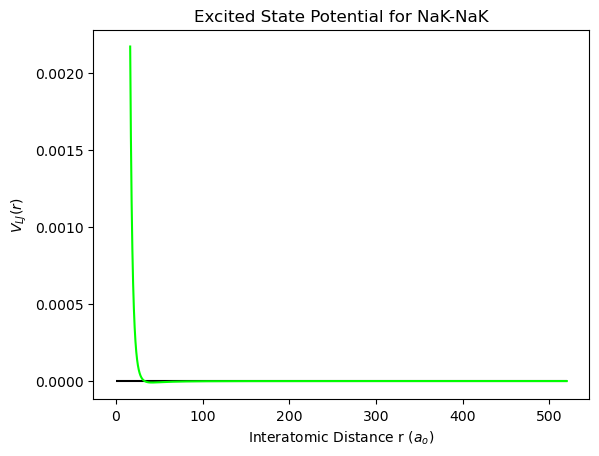

In [174]:
a = np.random.rand()
b = np.random.rand()
c = np.random.rand()
d_NaK = 1.07 # dipole moment for NaK in a.m.u.
C6_test = 5e4
Theta_A = np.arccos(1 - 2*a)
Theta_B = np.arccos(1 - 2*b)
PHI = 2*np.pi*c

print(f' Theta_A = {Theta_A}')
print(f' Theta_B = {Theta_B}')
print(f' Phi = {PHI}')

C_3_coef = ((d_NaK)**2)*(np.sin(Theta_A)*np.sin(Theta_B)*np.cos(PHI) - 2*np.cos(Theta_A)*np.cos(Theta_B))
V_dip_dip = (C6_test)/(r_grid**6) - (C_3_coef)/(r_grid**3)

assert C_3_coef > 0
#plt.plot(R_grid, V_dip_dip, color = 'lime')

plt.hlines(0,0, r_grid[-1], color = 'black')
plt.plot(r_grid, V_dip_dip, color = 'lime')
#plt.xlim(0,200)
#plt.ylim(-, 1e-12)
plt.ylabel('$V_{LJ}(r)$')
plt.xlabel('Interatomic Distance r $(a_o)$')
plt.title('Excited State Potential for NaK-NaK')

for i in range(len(V_dip_dip)):
    if abs(V_dip_dip[i] - min(V_dip_dip)) <= tol:
        print(r_grid[i])

print(f' min of VE = {min(V_dip_dip)}')

 min of VE = -9.506583274620494e-06


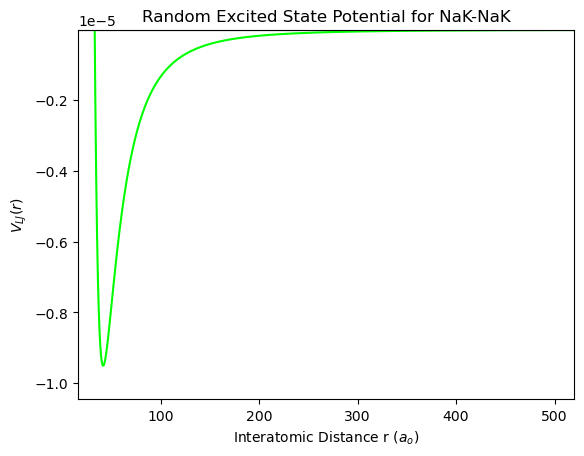

In [175]:
plt.hlines(0,0, r_grid[-1], color = 'black')
plt.plot(r_grid, V_dip_dip, color = 'lime')
plt.xlim(r1,r2)
plt.ylim(min(V_dip_dip) + 0.1*min(V_dip_dip), -1e-9)
plt.ylabel('$V_{LJ}(r)$')
plt.xlabel('Interatomic Distance r $(a_o)$')
plt.title('Random Excited State Potential for NaK-NaK')

print(f' min of VE = {min(V_dip_dip)}')



In [176]:
def Hamiltonian_DVR(a, b, dx, C6_coef, KE_matrix): # DVR method for finding bound states
    N = int((b-a)/dx) # Number of grid points
    ipaper = np.arange(1,N, 1.0) # indexing from the paper, given i = 1,2,...,N-1
    x = a + dx*ipaper # grid from paper
    
    for i in range(100):
        rand1 = np.random.rand()
        rand2 = np.random.rand()
        rand3 = np.random.rand()

        Theta_A = np.arccos(1 - 2*rand1)
        Theta_B = np.arccos(1 - 2*rand2)
        PHI = 2*np.pi*rand3
        C_3_coef = ((d_NaK)**2)*(np.sin(Theta_A)*np.sin(Theta_B)*np.cos(PHI) - 2*np.cos(Theta_A)*np.cos(Theta_B))
        if C_3_coef > 0:
            #print(i)
            break
    #C6_rand = np.random.randint(int(5e4), int(9.9e4))
    V_dip_dip = (C_3_coef)/(x**3)
    
    #Vx = C6_rand/(x**6) - V_dip_dip # Excited potential
    Vx = C6_coef/(x**6) - V_dip_dip # Excited potential
    plt.plot(x, Vx)
    Vx = np.insert(Vx,0,0) # Insert a 0 at the 0th index of list to account for mismatched indexing


    #print(f' ipaper = {ipaper}')
    #print(f' x = {x}')
    #print(f' N - 1 = {N-1}')
    #print(f' len(x) = {len(x)}')
    #print(x[-1]/(b-dx))
    #print(x[0]/(a+dx))
    #print(f' dx = {dx}')
    #print(f'dx from grid  = {x[1] - x[0]}')
    #print(Vx[len(Vx) - 1]/(0.5*(b - dx - d)**2))

    H_DVR = np.copy(KE_matrix) # Initialize empty Hamiltonian matrix of size N-1 x N-1
    Vmat = np.zeros((len(x) + 10, len(x) + 10))


    for i in ipaper:
        for j in ipaper:
            if int(i) == int(j): # fill in diagonal components of the Hamiltonian
                Vmat[int(i)][int(j)] = Vx[int(j)]
                
                H_DVR[int(i) - 1][int(j) - 1] += Vmat[int(i)][int(j)]
            

                
    assert(np.allclose(H_DVR, np.transpose(H_DVR)))
    #print(f' H = {H}')
    return H_DVR

In [177]:
time_start = time.time()
dr_DVR = 0.4
num_of_potentials = 200

#H = Hamiltonian_DVR(r1, r2, dr1) # Hamiltonian to construct excited potential bound states

#def T_Matrix(a, b, dx): # construct T matrix for DVR
xp_grids = []

Np = int((r2-r1)/dr_DVR) # Number of grid points
ipaperp = np.arange(1,Np, 1.0) # indexing from the paper, given i = 1,2,...,N-1
xp = r1 + dr_DVR*ipaperp # grid from paper
xp[0] = r1
xp[-1] = r2
xp_grids.append(xp)

    #print(f' ipaper = {ipaperp}')
    #print(f' xp[0] = {xp[0]}')
print(f' N - 1 = {Np-1}')
    #print(f' len(xp) = {len(xp)}')
    #print(x[-1]/(b-dx))
    #print(x[0]/(a+dx))
    #print(f' dx = {dx}')
    #print(f'dx from grid  = {xp[1] - xp[0]}')
    #print(Vx[len(Vx) - 1]/(0.5*(b - dx - d)**2))
    
Tmat = np.zeros((len(xp), len(xp))) # Initialize empty T matrix of size N-1 x N-1
KEmat = np.zeros((len(xp) + 10, len(xp) + 10))


for i in ipaperp:
    for j in ipaperp:
        if int(i) == int(j): # fill in diagonal components of the T matrix
            prefactorii = (np.pi**2)/(4*mu*(r2-r1)**2)
            bracketii = ((2*Np**2 + 1)/3) - (1/((np.sin(np.pi*(i/Np)))**2))
                
            KEmat[int(i)][int(j)] = prefactorii*bracketii
            Tmat[int(i) - 1][int(j) - 1] = KEmat[int(i)][int(j)]
            
        if i != j: # fill in off-diagonal components of the T matrix
            diff = i - j
            prefactorij = ((-1)**(diff))*(np.pi**2)/(4*mu*(r2-r1)**2)
            bracketij = (1/((np.sin(np.pi*((diff)/(2*Np))))**2)) - (1/((np.sin(np.pi*((i+j)/(2*Np))))**2))
                
            KEmat[int(i)][int(j)] = prefactorij*bracketij               
            Tmat[int(i) - 1][int(j) - 1] = KEmat[int(i)][int(j)]

    
    #assert(np.allclose(H_DVR, np.transpose(H_DVR)))
    #print(f' H = {H}')


time_end = time.time()
time_duration = time_end - time_start
print(f'Took {time_duration:.3f} seconds')

 N - 1 = 1257
Took 7.701 seconds


Took 159.761 seconds


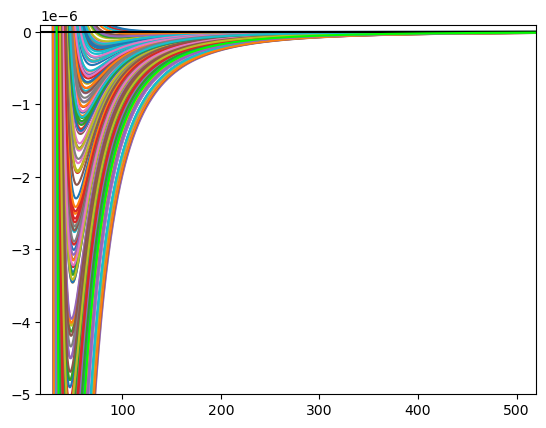

In [178]:
time_start = time.time()

H_vals_vecs = [ [] for i in range(num_of_potentials) ]
for i in range(num_of_potentials):  
    H_dr = Hamiltonian_DVR(r1, r2, dr_DVR, C6_test, Tmat)
    Heig = np.linalg.eigh(H_dr)[0]
    Heig = Heig[Heig<0]
    Eigvec = np.linalg.eigh(H_dr)[1]
    Hvec = []
    for j in range(len(Heig)):
        avec = Eigvec[:,j]
        Hvec.append(avec)
    for j in range(len(Hvec)):
        INT = np.trapz(np.abs(Hvec[j])**2,xp)
        A = 1/np.sqrt(INT)
        Hvec[j] = A*Hvec[j]
    H_vals_vecs[i].append([Heig,Hvec])

plt.hlines(0,0, r_grid[-1], color = 'black')
plt.plot(r_grid, V_dip_dip, color = 'lime')
plt.xlim(r1,r2)
plt.ylim(-5e-6, 1e-7)

time_end = time.time()
time_duration = time_end - time_start
print(f'Took {time_duration:.3f} seconds')



In [179]:
num_vals = []


for i in range(num_of_potentials):
    num_vals.append(len(H_vals_vecs[i][0][0]))
print(min(num_vals))
print(num_vals)

0
[4, 10, 30, 7, 28, 26, 16, 24, 11, 8, 19, 17, 24, 18, 22, 25, 25, 34, 11, 11, 9, 6, 28, 28, 13, 14, 1, 1, 5, 34, 6, 26, 21, 11, 22, 30, 36, 31, 16, 27, 31, 23, 26, 19, 25, 8, 10, 19, 37, 11, 13, 19, 7, 18, 12, 25, 4, 31, 25, 0, 17, 23, 26, 6, 38, 6, 9, 21, 30, 27, 4, 24, 23, 34, 19, 26, 10, 23, 18, 18, 11, 13, 4, 16, 13, 24, 10, 9, 21, 7, 24, 20, 26, 12, 9, 7, 6, 24, 9, 34, 29, 12, 4, 23, 36, 26, 31, 27, 22, 18, 19, 24, 4, 29, 25, 15, 15, 18, 5, 26, 10, 26, 13, 1, 8, 18, 13, 18, 24, 9, 7, 21, 13, 17, 26, 28, 15, 25, 16, 6, 20, 28, 24, 11, 4, 37, 14, 6, 35, 8, 7, 17, 19, 18, 21, 4, 14, 15, 15, 34, 22, 14, 22, 10, 4, 16, 29, 27, 29, 6, 0, 37, 24, 14, 31, 11, 8, 24, 20, 2, 14, 3, 27, 25, 12, 22, 19, 12, 29, 10, 28, 11, 13, 24, 31, 21, 10, 12, 23, 13]


[array([-9.34457511e-21, -1.85519253e-20, -2.77592754e-20, ...,
       -9.74910719e-17, -9.54038680e-17, -9.33166640e-17])]


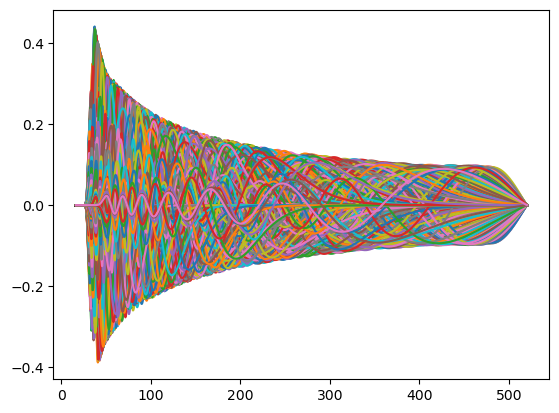

In [180]:
Phi_b = []
for i in range(num_of_potentials): 
    for j in range(len(H_vals_vecs[i][0][0])):
        if len(H_vals_vecs[i][0][0]) > 4:
            interp_wavefct = interpolate.interp1d(xp_grids[0], H_vals_vecs[i][0][1][j])
            Phi_B_interp = interp_wavefct(r_grid)
            Phi_b.append([Phi_B_interp])
print(Phi_b[1])
for i in range(len(Phi_b)):
    plt.plot(r_grid, Phi_b[i][0])

In [181]:
def Sigma_PA_hw(omega_range, index, Hamiltonian_eigvals_eigvecs, Collision_E): # calculate cross section over a range of laser frequencies
    
    VLJ_PA = (C12_coefs[index]/(R_grid**12)) - (C6/(R_grid**6))
    Psi_Scattering = Numerov(Eo, N_big - 1, VLJ_PA, dr1, R_grid)
    wave_num_sq = 2*mu*Eo
    
    Bound_Eigen_energies = [ [] for i in range(len(Hamiltonian_eigvals_eigvecs)) ]
    #print(Bound_Eigen_energies)
    Bound_Eigen_vecs = [ [] for i in range(len(Hamiltonian_eigvals_eigvecs)) ]
    #print(Bound_Eigen_vecs)
    K_N = []

    for i in range(len(Hamiltonian_eigvals_eigvecs)):
        #print(i)
        for j in range(comparison_n):
            #print(comparison_n)
            Bound_Eigen_energies[i].append(Hamiltonian_eigvals_eigvecs[i][0][j]) # collect all eigenvalues of the ith Hamiltonian
            Bound_Eigen_vecs[i].append(Hamiltonian_eigvals_eigvecs[i][1][j]) # collect all eigenvectors of the ith Hamiltonian
    for i in range(len(Hamiltonian_eigvals_eigvecs)):
        for j in range(len(Bound_Eigen_energies[i])):
            Bound_Eigen_energies[i][j] = H_to_GHz*Bound_Eigen_energies[i][j]
    #print(Bound_Eigen_energies[0])
    #print(Bound_Eigen_energies[1])
    
    Gamma0 = 100*gamma
    FC0 = np.abs(np.trapz(np.conjugate(Bound_Eigen_vecs[0][0])*Psi_Scattering[r1_i + 1:r2_i - 1], r_grid))**2
    U_squared = Gamma0/(2*np.pi*FC0)
    #print(f'U^2 = {U_squared}')

    for i in range(len(Hamiltonian_eigvals_eigvecs)):
        if i <= 10:
            for j in range(comparison_n):
           # if  j == 1 or j == 3:
                if  j <= 300:
                    FC_n = np.abs(np.trapz(np.conjugate(Bound_Eigen_vecs[i][j])*Psi_Scattering[r1_i + 1:r2_i - 1], r_grid))**2
                    Gamma_n = 2*np.pi*U_squared*FC_n
                    A_Gamma_Val = Gamma_n
        #plt.hlines(Gamma_n, -Gamma_n,Gamma_n, color = 'black')
        #print(f'n = {i}, Gamma/gamma = {Gamma_n/gamma}')
                    #print(f'VE{i}, n = {j}, Gamma = {Gamma_n}, Eb = {Bound_Eigen_energies[i][j]}')
        
                    Kn_num = -1*(Gamma_n*0.5)
        #print(f'Kn numerator = {Kn_num}')
        #Delta = omega_range - Bound_Eigen_energies[i]
        #print(f' Delta[0] = {Delta[0]}')
                    Detuning = (omega_range - Bound_Eigen_energies[i][j])
                    Kn_den = (H_to_GHz*Collision_E - Detuning) + I*gamma*0.5
        #print(f'Kn denominator = {Kn_den}')
                    Kn = np.array((Kn_num/Kn_den))
        #print(f'n= {i}, Kn = {Kn}')
                    K_N.append(Kn)

    K = sum(K_N)
    #plt.plot(omega_range,np.imag(K), color = 'purple')
    #print(f'K = Sum(K) = {K}')
    
    S_num = 1 + I*K
    #print(f'S numerator = {S_num}')
    S_den = 1 + -1*I*K
    #print(f'S denominator = {S_den}')
    S = S_num/S_den
    #print(f'S = {S}')
    S_prob = 1 - np.absolute(S)**2
    #print(f' |S|^2 = {np.absolute(S)**2}')
   # print(f'1 - |S|^2 = {S_prob}')

    #Sigma_PA_2 = (np.pi/wave_num_sq)*(S_prob)
    Sigma_PA_frequency = (S_prob)
    
    
    return(Sigma_PA_frequency, A_Gamma_Val)

In [182]:
comparison_n = 10
psi = np.zeros(len(R_grid))
gamma = 0.1
I = cmath.sqrt(-1)
Omega_1 = np.linspace(-150, -80, len(r_grid))
#H_E1 = [[Heig1,Hvec1]]
Bound_States = np.arange(0, comparison_n, 1.0)
#print(Heig[0])
#print(Heig[50])
#print(Bound_States)
#print(I)
My_Bound_State = 2


Sigma_S = Sigma_PA_hw(Omega_1, 121,  H_vals_vecs, Eo)
plt.plot(Delta_1, Sigma_S[0], color = 'firebrick', label = 'Cross section')
#print(Sigma_S)

plt.hlines(0.5*max(Sigma_S[0]), -0.5*Sigma_S[1], 0.5*Sigma_S[1], color = 'black')

#plt.xlim(Omega_1[0], Omega_1[-1])
#plt.ylim(min(Sigma_S), max(Sigma_S))
plt.xlabel(' $ \\Delta $ (GHz) ')
plt.ylabel(' $ \\sigma $')
plt.legend()
plt.title('PA cross section vs Detuning')

C:\Users\nienn\AppData\Local\Temp\ipykernel_26704\4260895120.py:12: RuntimeWarning: overflow encountered in scalar multiply
  psi[i] = ((2*(1 - (5/12)*(dr**2)*ksq[i-1])*psi[i-1]) - ((1 + (1/12)*(dr**2)*ksq[i-2])*psi[i-2]))/(1 + (1/12)*(dr**2)*ksq[i])
C:\Users\nienn\AppData\Local\Temp\ipykernel_26704\4260895120.py:12: RuntimeWarning: invalid value encountered in scalar subtract
  psi[i] = ((2*(1 - (5/12)*(dr**2)*ksq[i-1])*psi[i-1]) - ((1 + (1/12)*(dr**2)*ksq[i-2])*psi[i-2]))/(1 + (1/12)*(dr**2)*ksq[i])
C:\Users\nienn\AppData\Local\Temp\ipykernel_26704\4260895120.py:13: RuntimeWarning: invalid value encountered in divide
  Psi_f = psi/max(psi) # divide Psi by its largest value to qvoid it becoming too large


IndexError: list index out of range